<a href="https://colab.research.google.com/github/dcpatton/NLP/blob/master/watson_nli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import random

print(tf.__version__)
print(hub.__version__)

seed = 52
tf.random.set_seed(seed)
random.seed(seed)

2.3.0
0.9.0


# Get the Data from Kaggle

In [4]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls -l /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 64 Oct 17 13:30 /root/.kaggle/kaggle.json


In [5]:
!kaggle competitions download -c contradictory-my-dear-watson
!unzip test.csv.zip
!unzip train.csv.zip

  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 83.2MB/s]
  0% 0.00/66.0k [00:00<?, ?B/s]
100% 66.0k/66.0k [00:00<00:00, 59.9MB/s]
  0% 0.00/536k [00:00<?, ?B/s]
100% 536k/536k [00:00<00:00, 161MB/s]
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


# EDA

In [6]:
train_df = pd.read_csv("train.csv")
train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.sample(5)

,id,premise,hypothesis,lang_abv,language,label
8813,779336e8a1,"As the Tokugawa shoguns had feared, this openi...",There was no traumatic effect on japanese soci...,en,English,2
9940,4531625dd6,Ο πρώτος Δυτικός που έφτασε στη Χαβάη ήταν ο Κ...,Ο James Cook ταξιδεψε στη Χαβάη.,el,Greek,0
9420,00d4ce037e,"Нельзя поднять тяжесть, как эта, конечно если ...",Они не могут утонуть ни при каких обстоятельст...,ru,Russian,2
7006,ada7c6260e,"Bir İç Çember üyesi olarak, dünyanın en büyük ...",Amerika Başkanlık Töreni dünyanın en büyük dem...,tr,Turkish,0
11558,343c6fc35d,"In both Britain and America, the term covers n...",In both Britain and America the term covers al...,en,English,0


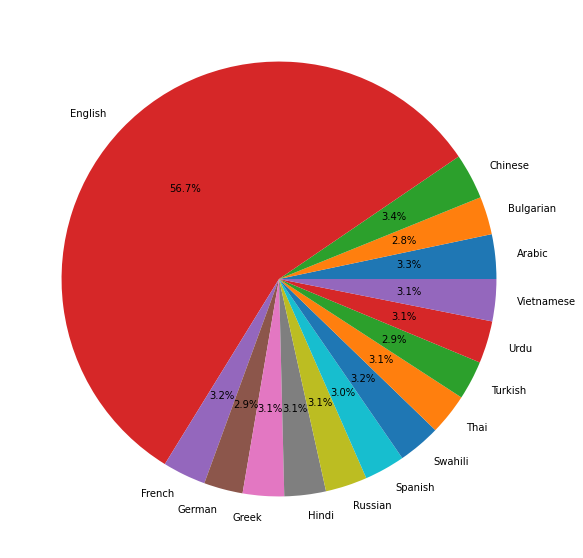

In [7]:
import matplotlib.pyplot as plt

labels, frequencies = np.unique(train_df.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


In [9]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2)

In [10]:
def get_model(model_url, max_seq_length):
    labse_layer = hub.KerasLayer(model_url, trainable=False)

    # Define input.
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

    # LaBSE layer.
    pooled_output,  _ = labse_layer([input_word_ids, input_mask, segment_ids])

    # The embedding is l2 normalized.
    x = tf.keras.layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))(pooled_output)
    
    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ELU()(x)
    output = tf.keras.layers.Dense(3, activation='softmax')(x)

    # Define model.
    return tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids],outputs=output), labse_layer

max_seq_length = 128

model, labse_layer = get_model(model_url="https://tfhub.dev/google/LaBSE/1", max_seq_length=max_seq_length)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 470926849   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [11]:
!pip install bert-for-tf2 -q

import bert

vocab_file = labse_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = labse_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

def create_input(input_strings, tokenizer, max_seq_length):

    input_ids_all, input_mask_all, segment_ids_all = [], [], []
    for input_string in input_strings:
        # Tokenize input.
        input_tokens = ["[CLS]"] + tokenizer.tokenize(input_string) + ["[SEP]"]
        input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
        sequence_length = min(len(input_ids), max_seq_length)

        # Padding or truncation.
        if len(input_ids) >= max_seq_length:
            input_ids = input_ids[:max_seq_length]
        else:
            input_ids = input_ids + [0] * (max_seq_length - len(input_ids))

        input_mask = [1] * sequence_length + [0] * (max_seq_length - sequence_length)

        input_ids_all.append(input_ids)
        input_mask_all.append(input_mask)
        segment_ids_all.append([0] * max_seq_length)

    return np.array(input_ids_all), np.array(input_mask_all), np.array(segment_ids_all)

     |████████████████████████████████| 40kB 2.9MB/s 


In [12]:
def encode_text(df):
    input_strings = []
    for _,row in df.iterrows():
        input_strings.append(row.premise + ' ' + row.hypothesis)
    
    return create_input(input_strings, tokenizer, max_seq_length)

input_ids, input_masks, segment_ids = encode_text(train_df)
x_train = [input_ids, input_masks, segment_ids]
input_ids, input_masks, segment_ids = encode_text(val_df)
x_val = [input_ids, input_masks, segment_ids]

In [13]:
y_train = train_df['label'].values
y_train = tf.keras.utils.to_categorical(y_train)
y_val = val_df['label'].values
y_val = tf.keras.utils.to_categorical(y_val)

In [14]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['acc'])

In [15]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=200, verbose=1, validation_data=(x_val, y_val), batch_size=32, 
                    callbacks=[es])

Epoch 1/200
  2/303 [..............................] - ETA: 23s - loss: 1.3048 - acc: 0.3281WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0125s vs `on_train_batch_end` time: 0.1452s). Check your callbacks.


303/303 [==============================] - 61s 202ms/step - loss: 1.1837 - acc: 0.4218 - val_loss: 1.0568 - val_acc: 0.4526
Epoch 2/200
303/303 [==============================] - 61s 202ms/step - loss: 1.0344 - acc: 0.4818 - val_loss: 1.0374 - val_acc: 0.4711
Epoch 3/200
303/303 [==============================] - 60s 197ms/step - loss: 1.0066 - acc: 0.4968 - val_loss: 1.0314 - val_acc: 0.4872
Epoch 4/200
303/303 [==============================] - 60s 197ms/step - loss: 0.9969 - acc: 0.5052 - val_loss: 1.0223 - val_acc: 0.4909
Epoch 5/200
303/303 [==============================] - 59s 193ms/step - loss: 0.9866 - acc: 0.5176 - val_loss: 1.0296 - val_acc: 0.4864
Epoch 6/200
303/303 [==============================] - 59s 193ms/step - loss: 0.9772 - acc: 0.5213 - val_loss: 1.0302 - val_acc: 0.4880
Epoch 7/200
303/303 [==============================] - 60s 197ms/step - loss: 0.9697 - acc: 0.5290 - val_loss: 1.0196 - val_acc: 0.5017
Epoch 8/200
303/303 [==============================] - 59s 1

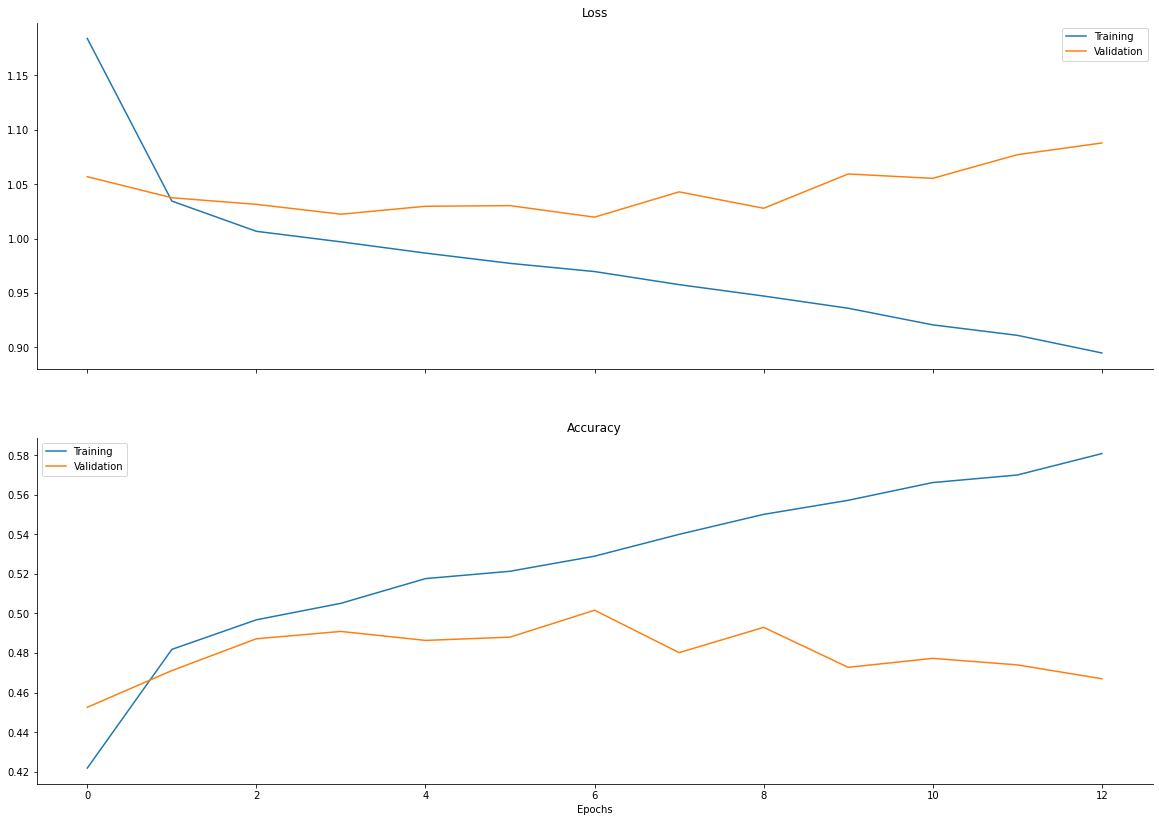

In [16]:
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Training')
ax2.plot(history['val_acc'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [17]:
model.get_layer(index=3).trainable=True
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 470926849   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [18]:
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=1e-6), 
              metrics=['acc'])

In [19]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=11, verbose=1, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=100, verbose=2, validation_data=(x_val, y_val), batch_size=32, 
                    callbacks=[es])

Epoch 1/100
303/303 - 179s - loss: 0.9170 - acc: 0.5744 - val_loss: 0.9657 - val_acc: 0.5330
Epoch 2/100
303/303 - 178s - loss: 0.8736 - acc: 0.6034 - val_loss: 0.9304 - val_acc: 0.5631
Epoch 3/100
303/303 - 179s - loss: 0.8387 - acc: 0.6279 - val_loss: 0.8937 - val_acc: 0.5887
Epoch 4/100
303/303 - 178s - loss: 0.8031 - acc: 0.6442 - val_loss: 0.8540 - val_acc: 0.6122
Epoch 5/100
303/303 - 178s - loss: 0.7610 - acc: 0.6705 - val_loss: 0.8143 - val_acc: 0.6386
Epoch 6/100
303/303 - 178s - loss: 0.7235 - acc: 0.6921 - val_loss: 0.7756 - val_acc: 0.6650
Epoch 7/100
303/303 - 178s - loss: 0.6863 - acc: 0.7112 - val_loss: 0.7462 - val_acc: 0.6823
Epoch 8/100
303/303 - 178s - loss: 0.6556 - acc: 0.7238 - val_loss: 0.7241 - val_acc: 0.6914
Epoch 9/100
303/303 - 178s - loss: 0.6294 - acc: 0.7438 - val_loss: 0.7074 - val_acc: 0.6964
Epoch 10/100
303/303 - 178s - loss: 0.6022 - acc: 0.7564 - val_loss: 0.6991 - val_acc: 0.7071
Epoch 11/100
303/303 - 178s - loss: 0.5779 - acc: 0.7649 - val_loss: 

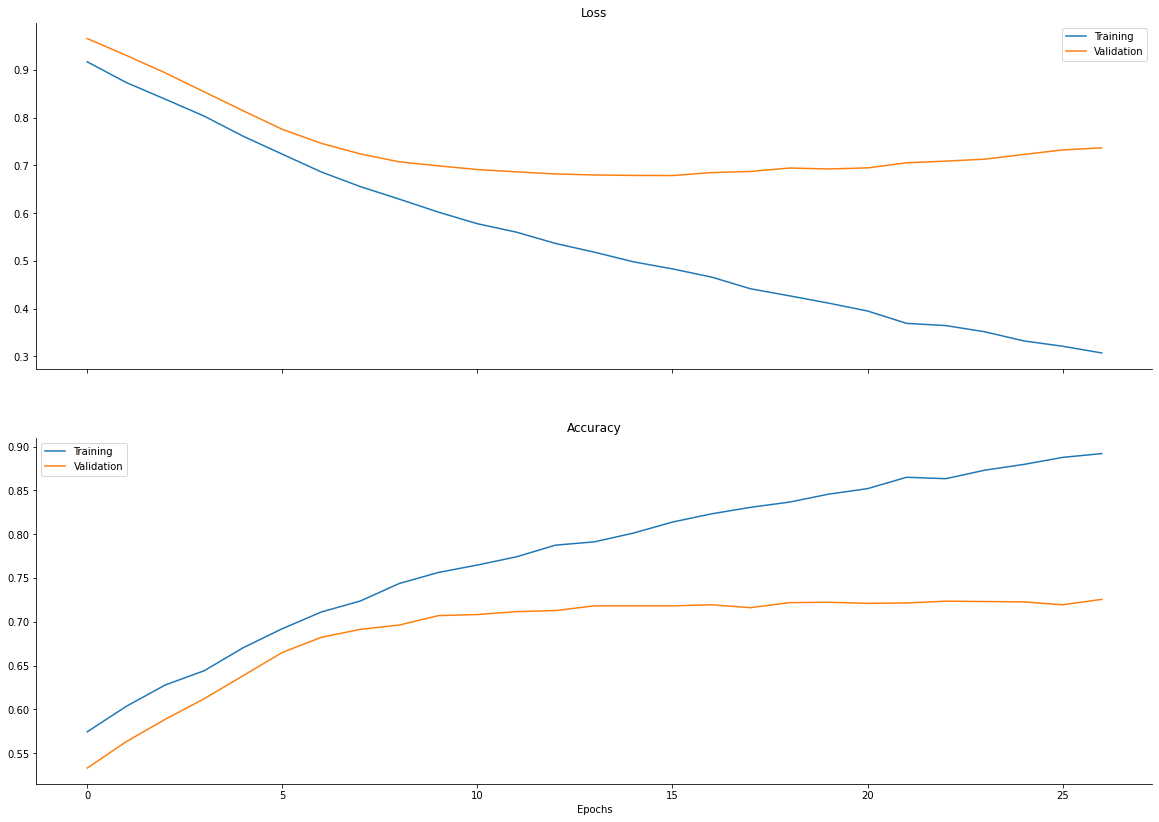

In [20]:
history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Training')
ax1.plot(history['val_loss'], label='Validation')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Training')
ax2.plot(history['val_acc'], label='Validation')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [25]:
model.evaluate(x_val, y_val)

76/76 [==============================] - 12s 155ms/step - loss: 0.6788 - acc: 0.7182


[0.6787723302841187, 0.7182343006134033]

In [21]:
# test_df = pd.read_csv('test.csv')
# input_ids, input_masks, segment_ids = encode_text(test_df)
# x_test = [input_ids, input_masks, segment_ids]

In [22]:
# predictions = [np.argmax(i) for i in model.predict(x_test)]

In [23]:
# submission = test_df.id.copy().to_frame()
# submission['prediction'] = predictions

# submission.to_csv("submission.csv", index = False)

In [24]:
# !kaggle competitions submit contradictory-my-dear-watson -f submission.csv -m "from colab"

# 403 - This competition only allows kernel submissions.

100% 66.0k/66.0k [00:03<00:00, 18.9kB/s]
403 - This competition only allows kernel submissions.
